Comparison of accuracies for differet classifiers

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report
import pickle
import pandas as pd
import numpy as np
import os
from os.path import exists

file_data = '..' + os.sep + 'data' + os.sep + 'metadata.csv'
file_features = 'features/features_original.csv'

# Read metadata
metadata_df = pd.read_csv(file_data)
df_features = pd.read_csv(file_features)
feature_names = ['asymmetry', 'colours', 'dots and globules', 'compactness']
# Merging created annotations with patient details
combined_df = df_features.merge(metadata_df[['img_id', 'diagnostic', 'patient_id']], left_on='image_id', right_on='img_id', how='left')
if combined_df.isnull().values.any():
    raise ValueError("NaN values detected after merge! Check the data integrity.")

# Preparing the dataset
#defining canserous diagnosis
combined_df['target'] = np.logical_or(combined_df['diagnostic'].values == 'BCC', combined_df['diagnostic'].values == 'MEL', combined_df['diagnostic'].values == 'SCC') 
patient_id = combined_df['patient_id'].values
y = combined_df['target'].values
X = combined_df[feature_names].values


# Preparing cross-validation
num_folds = 5
group_kfold = GroupKFold(n_splits=num_folds)

# Initialize classifiers with appropriate names
classifiers = [
    KNeighborsClassifier(1),
    KNeighborsClassifier(5),
    RandomForestClassifier(n_estimators=100, random_state=42),
    GradientBoostingClassifier(n_estimators=100, random_state=42),
    AdaBoostClassifier(n_estimators=100, random_state=42),
    DecisionTreeClassifier(random_state=42),
    make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000)),
    make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, class_weight='balanced')),
    make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3)),
    GaussianNB()
]

classifier_names = [
    "KNeighbors (n=1)", "KNeighbors (n=5)", 
    "RandomForest", "GradientBoosting", 
    "AdaBoost", "DecisionTree", 
    "LogisticRegression (Std)", "LogisticRegression (Std, Balanced)",
    "SGDClassifier (Std)", "GaussianNB"
]

# Initializing accuracy storage
acc_val = np.empty((num_folds, len(classifiers)))

# Preparing the directory for saving classifier files
classifiers_save_path = 'Trained_classifiers'  
if not os.path.exists(classifiers_save_path):
    os.makedirs(classifiers_save_path)

# Performing cross-validation
for j, clf in enumerate(classifiers):
    fold_accuracies = []
    for i, (train_index, val_index) in enumerate(group_kfold.split(X, y, patient_id)):
        x_train, y_train = X[train_index], y[train_index]
        x_val, y_val = X[val_index], y[val_index]
        
        # Fitting and predicting
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_val)
        acc = accuracy_score(y_val, y_pred)
        fold_accuracies.append(acc)
        
        # Saving the classifier after training on this fold
        fold_filename = f'{classifier_names[j]}_fold_{i}.sav'
        fold_path = os.path.join(classifiers_save_path, fold_filename)
        pickle.dump(clf, open(fold_path, 'wb'))
    
    acc_val[:, j] = fold_accuracies

# Calculating average accuracy for each classifier
average_acc = np.mean(acc_val, axis=0)
for idx, acc in enumerate(average_acc):
    print(f'Classifier {classifier_names[idx]}: average accuracy={acc:.3f}')

# Saving and evaluating each classifier on the full dataset
eval_results = {}
for idx, clf in enumerate(classifiers):
    
    classifier_filename = f'{classifier_names[idx]}.sav'
    full_classifier_path = os.path.join(classifiers_save_path, classifier_filename)
    
    # Saving classifier
    with open(full_classifier_path, 'wb') as f:
        pickle.dump(clf, f)
    
    # Loading classifier
    with open(full_classifier_path, 'rb') as f:
        loaded_clf = pickle.load(f)
    
    # Predicting on the full dataset and calculating evaluation metrics
    y_pred = loaded_clf.predict(X)
    acc = accuracy_score(y, y_pred)
    clf_report = classification_report(y, y_pred)
    
    eval_results[classifier_names[idx]] = {'accuracy': acc, 'report': clf_report}


# Displaying evaluation results
for clf_name, results in eval_results.items():
    print(f"Results for {clf_name}:")
    print(f"Accuracy: {results['accuracy']}")
    #print(f"Classification Report:\n{results['report']}\n")

c:\Users\tettret\Downloads\Anaconda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\tettret\Downloads\Anaconda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\tettret\Downloads\Anaconda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\tettret\Downloads\Anaconda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Classifier KNeighbors (n=1): average accuracy=0.524
Classifier KNeighbors (n=5): average accuracy=0.523
Classifier RandomForest: average accuracy=0.526
Classifier GradientBoosting: average accuracy=0.589
Classifier AdaBoost: average accuracy=0.591
Classifier DecisionTree: average accuracy=0.528
Classifier LogisticRegression (Std): average accuracy=0.587
Classifier LogisticRegression (Std, Balanced): average accuracy=0.495
Classifier SGDClassifier (Std): average accuracy=0.545
Classifier GaussianNB: average accuracy=0.567
Results for KNeighbors (n=1):
Accuracy: 0.8190572731880386
Results for KNeighbors (n=5):
Accuracy: 0.670045615813482
Results for RandomForest:
Accuracy: 0.8246325392802838
Results for GradientBoosting:
Accuracy: 0.6614292954891029
Results for AdaBoost:
Accuracy: 0.6249366447034972
Results for DecisionTree:
Accuracy: 0.8220983274201723
Results for LogisticRegression (Std):
Accuracy: 0.5879371515458692
Results for LogisticRegression (Std, Balanced):
Accuracy: 0.494678155

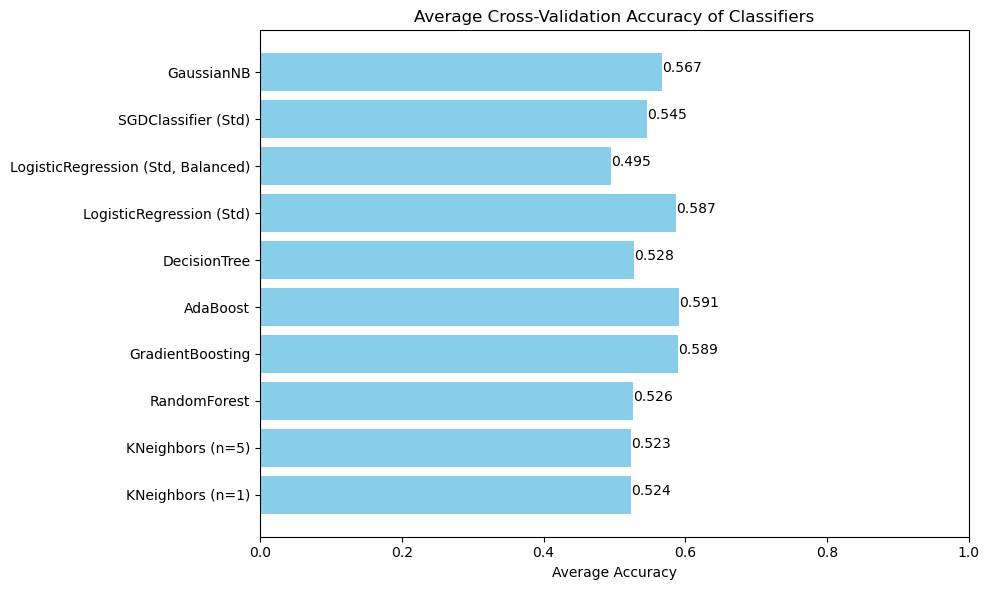

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Example data for visualization
classifier_names = [
    "KNeighbors (n=1)", "KNeighbors (n=5)", 
    "RandomForest", "GradientBoosting", 
    "AdaBoost", "DecisionTree", 
    "LogisticRegression (Std)", "LogisticRegression (Std, Balanced)",
    "SGDClassifier (Std)", "GaussianNB"
]

# Assuming 'average_acc' contains average accuracies for these classifiers
#average_acc = np.array([0.85, 0.88, 0.92, 0.91, 0.89, 0.87, 0.90, 0.89, 0.88, 0.86])

# Creating the bar plot
plt.figure(figsize=(10, 6))
plt.barh(classifier_names, average_acc, color='skyblue')
plt.xlabel('Average Accuracy')
plt.title('Average Cross-Validation Accuracy of Classifiers')
plt.xlim([0, 1])  # Assuming accuracy is between 0 and 1
plt.tight_layout()

# Adding the accuracy values on the bar
for index, value in enumerate(average_acc):
    plt.text(value, index, f'{value:.3f}')

# Saving the plot as a PNG file
plt.savefig('classifier_accuracies.png', dpi=300)  

plt.show()

Confusion matrix for each fold

In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from extract_features import  process_images

# Defining path to metadata and testing set
data_dir = os.path.join('..', 'data')
features_path = os.path.join(data_dir, 'metadata.csv')
path_image = os.path.join(data_dir, 'images', 'images_evaluate')
path_mask = os.path.join(data_dir, 'images', 'masks_evaluate')

# Assume process_images is defined elsewhere to process the images and extract features
feature_names = ['asymmetry', 'colours', 'dots and globules', 'compactness']
features_df = process_images(features_path, path_image, path_mask, feature_names)

# Loading metadata
metadata_df = pd.read_csv(features_path)
combined_df = features_df.merge(metadata_df[['img_id', 'diagnostic', 'patient_id']], left_on='image_id', right_on='img_id', how='left')

# Defining the target variable 'y' where '1' represents cancerous conditions and '0' represents non-cancerous conditions
cancerous_conditions = ['BCC', 'MEL', 'SCC']
combined_df['target'] = combined_df['diagnostic'].apply(lambda x: 1 if x in cancerous_conditions else 0)
y = combined_df['target'].values
X = combined_df[feature_names].values
patient_id = combined_df['patient_id']

def load_and_evaluate(model_filename, X, y):
    try:
        with open(model_filename, 'rb') as model_file:
            classifier = pickle.load(model_file)
        classifier_name = os.path.basename(model_filename).split('.')[0]  # Extract the name without extension
        print(f"Loaded classifier: {classifier_name} from {model_filename}")
    except Exception as e:
        print(f"An error occurred while loading the model from {model_filename}: {e}")
        return None, None

    pred_labels = classifier.predict(X)
    accuracy = accuracy_score(y, pred_labels)
    cm = confusion_matrix(y, pred_labels)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False,
                xticklabels=['Non-cancerous', 'Cancerous'],
                yticklabels=['Non-cancerous', 'Cancerous'])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix for {classifier_name}')
    plt.show()
    
    return accuracy, cm

# Using glob to find all classifier files
classifier_dir = 'Trained_classifiers'
classifier_filenames = glob.glob(os.path.join(classifier_dir, '*.sav'))

# Evaluating all classifiers
for model_filename in classifier_filenames:
    accuracy, cm = load_and_evaluate(model_filename, X, y)
    if accuracy is not None:
        classifier_name = os.path.basename(model_filename).split('.')[0]  # Extract the name for labeling
        print(f"Results for {classifier_name}:")
        print("Accuracy:", accuracy)

Plotting recall and precision

c:\Users\tettret\Downloads\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tettret\Downloads\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tettret\Downloads\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tettret\Downloads\Anac

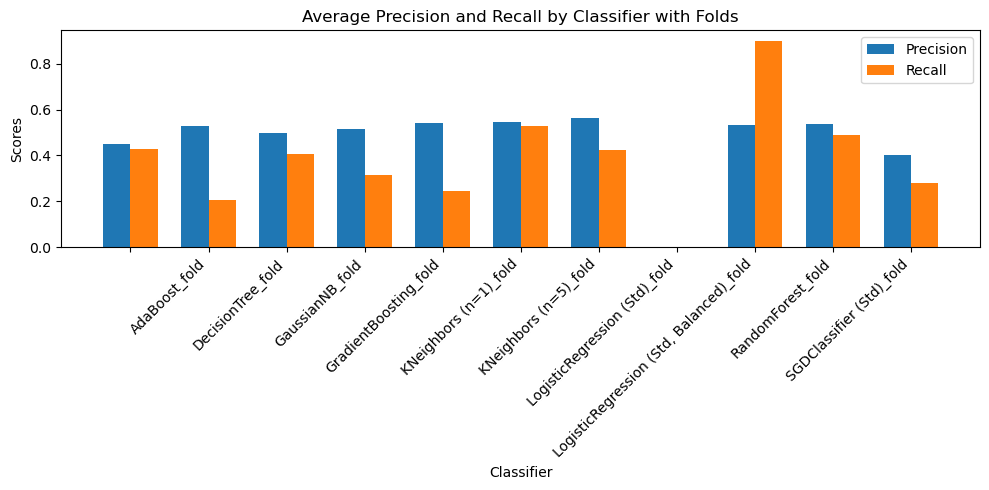

In [27]:
from sklearn.metrics import precision_recall_fscore_support

def load_and_evaluate(model_filename, X, y):
    try:
        with open(model_filename, 'rb') as model_file:
            classifier = pickle.load(model_file)
        classifier_name = os.path.basename(model_filename).split('.')[0]  # Extracting the name without extension
        pred_labels = classifier.predict(X)
        accuracy = accuracy_score(y, pred_labels)
        cm = confusion_matrix(y, pred_labels)
        precision, recall, fscore, _ = precision_recall_fscore_support(y, pred_labels, average='binary')
        return accuracy, cm, precision, recall
    except Exception as e:
        print(f"An error occurred while loading or evaluating the model from {model_filename}: {e}")
        # Return zeros or NaNs as default failure-case outputs
        return 0, np.array([[0, 0], [0, 0]]), 0, 0

results = {}

for model_filename in classifier_filenames:
    accuracy, cm, precision, recall = load_and_evaluate(model_filename, X, y)
    if accuracy != 0:  # Check for successful evaluation
        parts = os.path.basename(model_filename).split('_')
        classifier_base_name = '_'.join(parts[:-1])  
        fold_number = parts[-1].split('.')[0]  
        
        if classifier_base_name not in results:
            results[classifier_base_name] = {'precision': [], 'recall': []}
        
        results[classifier_base_name]['precision'].append(precision)
        results[classifier_base_name]['recall'].append(recall)

# Compute average precision and recall for classifiers with folds
averaged_results = {}
for classifier_name, data in results.items():
    if len(data['precision']) > 1:  
        avg_precision = np.mean(data['precision'])
        avg_recall = np.mean(data['recall'])
        averaged_results[classifier_name] = {'avg_precision': avg_precision, 'avg_recall': avg_recall}

labels = list(averaged_results.keys())
precision_scores = [averaged_results[clf]['avg_precision'] for clf in labels]
recall_scores = [averaged_results[clf]['avg_recall'] for clf in labels]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 5)) 
rects1 = ax.bar(x - width/2, precision_scores, width, label='Precision')
rects2 = ax.bar(x + width/2, recall_scores, width, label='Recall')

ax.set_xlabel('Classifier')
ax.set_ylabel('Scores')
ax.set_title('Average Precision and Recall by Classifier with Folds')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')  # Rotating labels for better readability
ax.legend()

fig.tight_layout()  
plt.show()

Average confusion matrix

c:\Users\tettret\Downloads\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tettret\Downloads\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tettret\Downloads\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tettret\Downloads\Anac

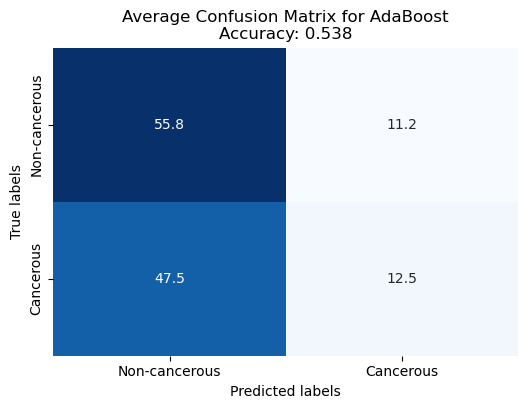

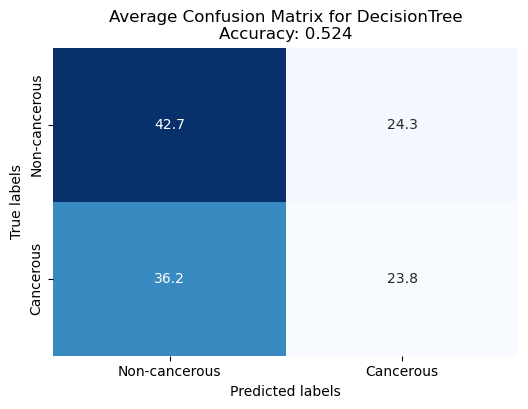

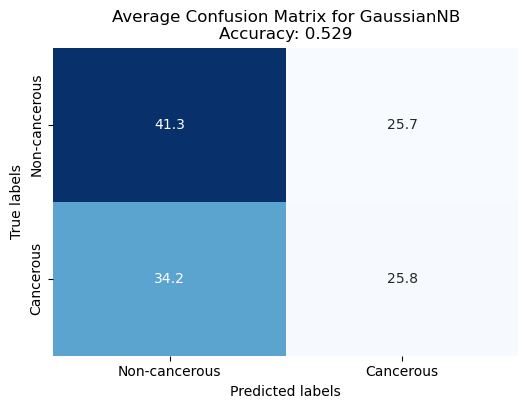

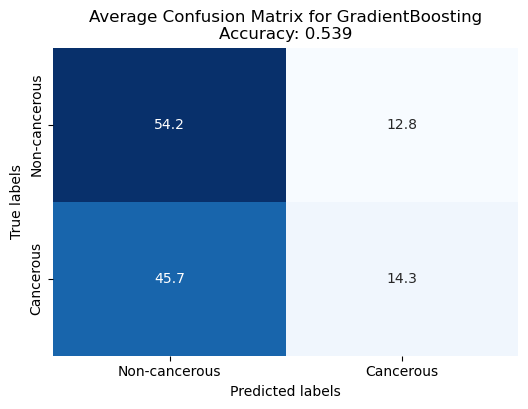

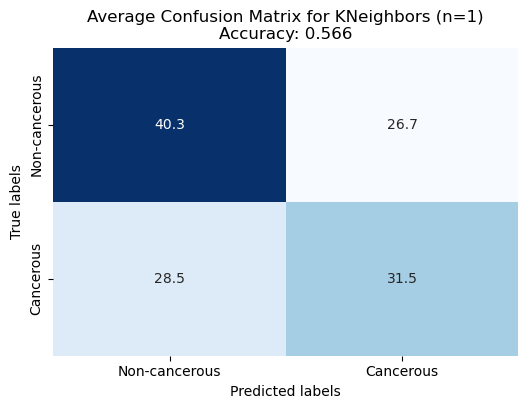

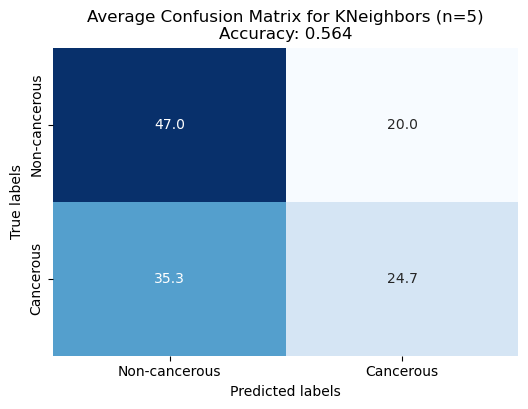

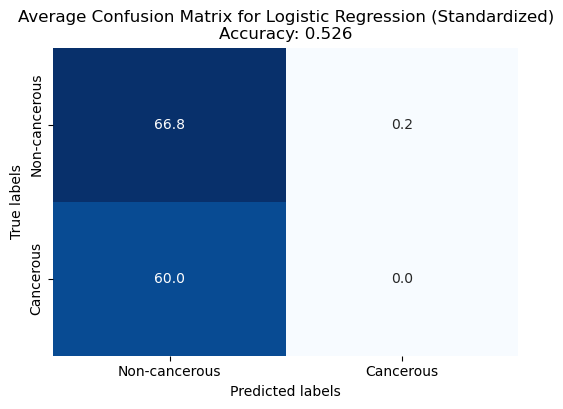

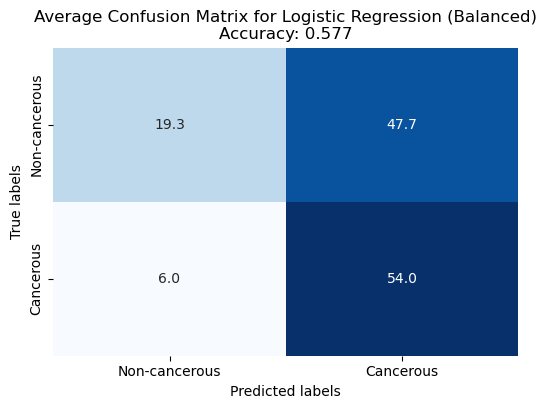

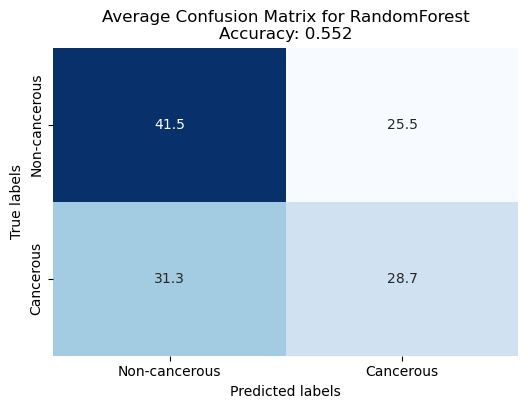

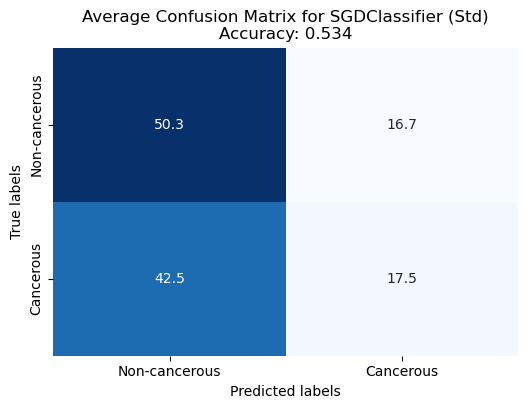

In [28]:
import re
import matplotlib.pyplot as plt
import seaborn as sns


def normalize_classifier_name(name):
    # Removing file extension
    name = name.replace('.sav', '')
    
    # Customing handling for KNeighbors to preserve the n value
    if 'KNeighbors' in name:
        match = re.search(r'KNeighbors \(n=(\d+)\)', name)
        if match:
            return f"KNeighbors (n={match.group(1)})"
    
    # Handling for Logistic Regression
    if 'LogisticRegression' in name:
        if 'Balanced' in name:
            return 'Logistic Regression (Balanced)'
        elif 'Std' in name:
            return 'Logistic Regression (Standardized)'
        return 'Logistic Regression'

    # General clean-up for other classifiers: remove _fold and any numeric suffixes
    name = re.sub(r'_fold', '', name)
    name = re.sub(r'\d+$', '', name)
    return name.replace('_', ' ').strip()

results = {}

for model_filename in classifier_filenames:
    accuracy, cm, precision, recall = load_and_evaluate(model_filename, X, y)
    if accuracy != 0:  # Check for successful evaluation
        parts = os.path.basename(model_filename).split('_')
        classifier_base_name = '_'.join(parts[:-1]) if parts[-1].isdigit() else '_'.join(parts)
        normalized_name = normalize_classifier_name(classifier_base_name)
        
        if normalized_name not in results:
            results[normalized_name] = {'conf_matrix': [], 'accuracy': []}
        
        results[normalized_name]['conf_matrix'].append(cm)
        results[normalized_name]['accuracy'].append(accuracy)

# Function to compute the average of confusion matrices and accuracy
def average_confusion_matrix(matrices):
    sum_matrix = np.sum(matrices, axis=0)
    avg_matrix = sum_matrix / len(matrices)
    return np.round(avg_matrix, 1)

def average_accuracy(accuracies):
    return np.round(np.mean(accuracies), 3)

# Plot the average confusion matrices with average accuracy
for classifier, data in results.items():
    if len(data['conf_matrix']) > 0:
        avg_cm = average_confusion_matrix(data['conf_matrix'])
        avg_accuracy = average_accuracy(data['accuracy'])  # Calculate average accuracy
        
        plt.figure(figsize=(6, 4))
        ax = sns.heatmap(avg_cm, annot=True, fmt=".1f", cmap='Blues', cbar=False,
                         xticklabels=['Non-cancerous', 'Cancerous'],
                         yticklabels=['Non-cancerous', 'Cancerous'])
        # Update title to include average accuracy
        ax.set_title(f'Average Confusion Matrix for {classifier}\nAccuracy: {avg_accuracy}')
        ax.set_xlabel('Predicted labels')
        ax.set_ylabel('True labels')
        plt.show()